# Mixed (invasion) Percolation

In [1]:
import openpnm as op
from openpnm.algorithms import MixedInvasionPercolation as mp
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider
%matplotlib inline
wrk = op.Workspace()
wrk.settings['loglevel'] = 50

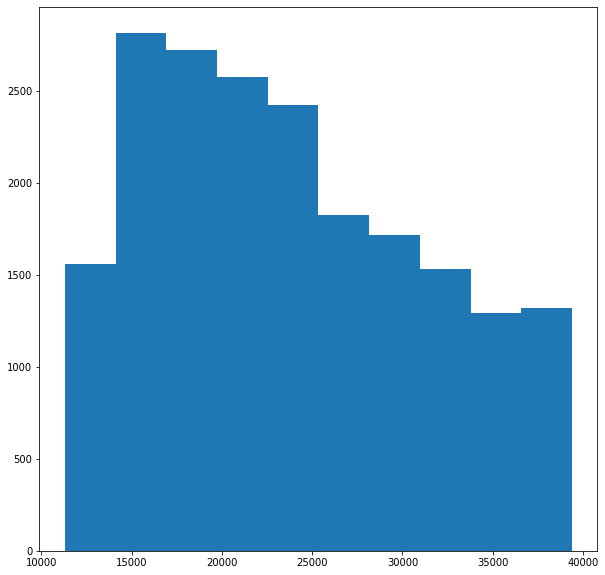

In [2]:
N = 100
net = op.network.Cubic(shape=[N, N, 1], spacing=2.5e-5)
geom = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)
water = op.phases.Water(network=net)
phys = op.physics.Standard(network=net, phase=water, geometry=geom)
phys['pore.entry_pressure'] = 0.0
fig, ax = plt.subplots(figsize=[10, 10])
ax.hist(phys['throat.entry_pressure'])
plt.show()

In [3]:
def run_mp(trapping=False, residual=None, snap_off=False, plot=True, flowrate=None, phase=None):
    alg = mp(network=net)
    if snap_off:
        alg.settings['snap_off'] = 'throat.snap_off'
    alg.setup(phase=phase)
    alg.set_inlets(pores=net.pores('left'))
    if residual is not None:
        alg.set_residual(pores=residual)
    alg.run()
    if trapping:
        alg.set_outlets(net.pores('right'))
        alg.apply_trapping()
    inv_points = np.arange(0, 100, 1)
    # returns data as well as plotting
    alg_data = alg.get_intrusion_data(inv_points=inv_points)
    water.update(alg.results(Pc=inv_points.max()))
    if plot:
        fig, ax = plt.subplots(figsize=[10, 10])
        L = np.sqrt(net.Np).astype(int)
        ax.imshow(alg['pore.invasion_sequence'].reshape([L, L]),
                   cmap=plt.get_cmap('Blues'))
        plt.show()
    if flowrate is not None:
        alg.apply_flow(flowrate=flowrate)
    return alg

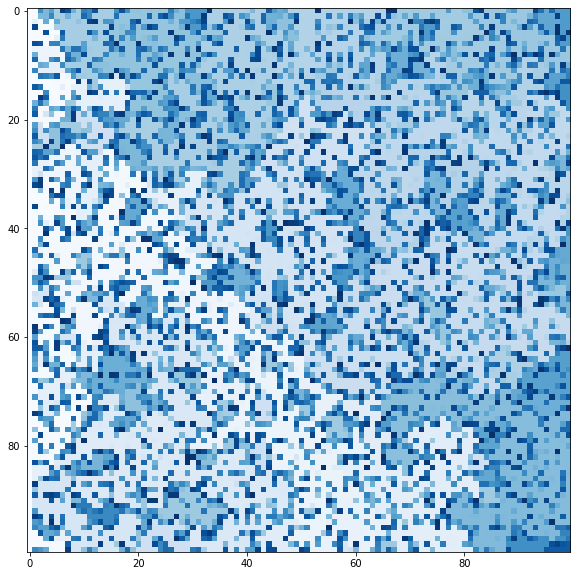

In [4]:
alg1 = run_mp(phase=water)

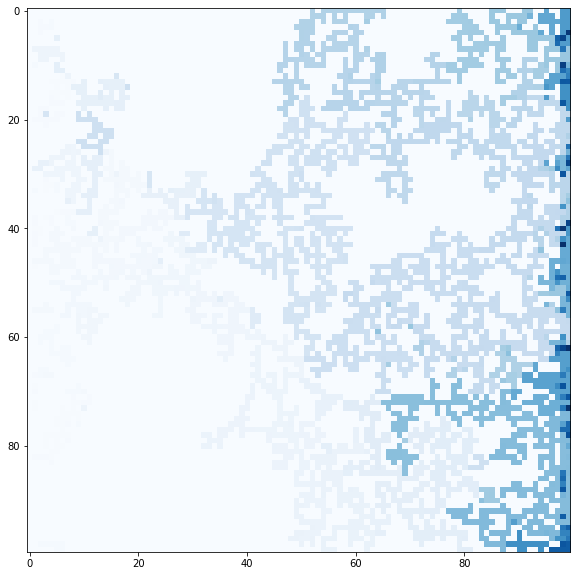

In [5]:
alg2 = run_mp(phase=water, trapping=True)

c:\code\openpnm-working\openpnm\algorithms\MixedInvasionPercolation.py:548: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  a = fig.add_subplot(111)


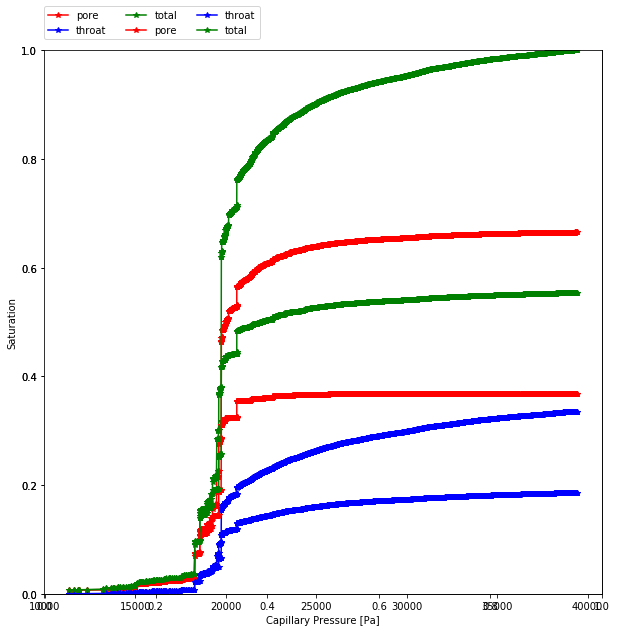

In [6]:
fig, ax = plt.subplots(figsize=[10, 10])
fig = alg1.plot_intrusion_curve(fig)
fig = alg2.plot_intrusion_curve(fig)

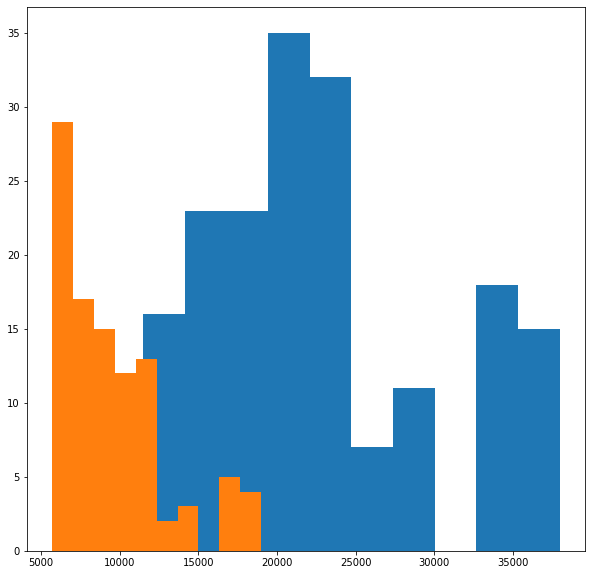

In [7]:
N = 10
net = op.network.Cubic(shape=[N, N, 1], spacing=2.5e-5)
geom = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)
water = op.phases.Water(network=net)
phys = op.physics.Standard(network=net, phase=water, geometry=geom)
phys.add_model(propname='pore.entry_pressure',
               model=op.models.physics.capillary_pressure.washburn,
               diameter='pore.diameter')
fig, ax = plt.subplots(figsize=[10, 10])
ax.hist(phys['throat.entry_pressure'])
ax.hist(phys['pore.entry_pressure'])
plt.show()

In [8]:
alg1 = run_mp(phase=water, plot=False)

In [9]:
from openpnm.topotools import plot_coordinates, plot_connections

In [10]:
alg1.props()

['pore.cluster', 'pore.entry_pressure', 'pore.invasion_pressure', 'pore.invasion_saturation', 'pore.invasion_sequence', 'pore.trapped', 'throat.cluster', 'throat.entry_pressure', 'throat.invasion_pressure', 'throat.invasion_saturation', 'throat.invasion_sequence', 'throat.trapped']

In [11]:
def plot_invasion_sequence(seq):
    pmask = alg1['pore.invasion_sequence'] < seq
    tmask = alg1['throat.invasion_sequence'] < seq
    fig, ax = plt.subplots(figsize=[10, 10])
    fig = plot_connections(network=net, throats=net.Ts[~tmask], c='k', linestyle='dashed', fig=fig)
    fig = plot_connections(network=net, throats=net.Ts[tmask], c='b', fig=fig)
    fig = plot_coordinates(network=net, pores=net.Ps[pmask], c='b', fig=fig)
    title = 'Invaded pores: '+str(np.sum(pmask))+' Invaded throats: '+str(np.sum(tmask))
    plt.title(title)
    plt.show()

In [12]:
interact(plot_invasion_sequence, seq=IntSlider(min=1, max=alg1['throat.invasion_sequence'].max(), step=1, value=1))

interactive(children=(IntSlider(value=1, description='seq', max=270, min=1), Output()), _dom_classes=('widget-…

<function __main__.plot_invasion_sequence(seq)>

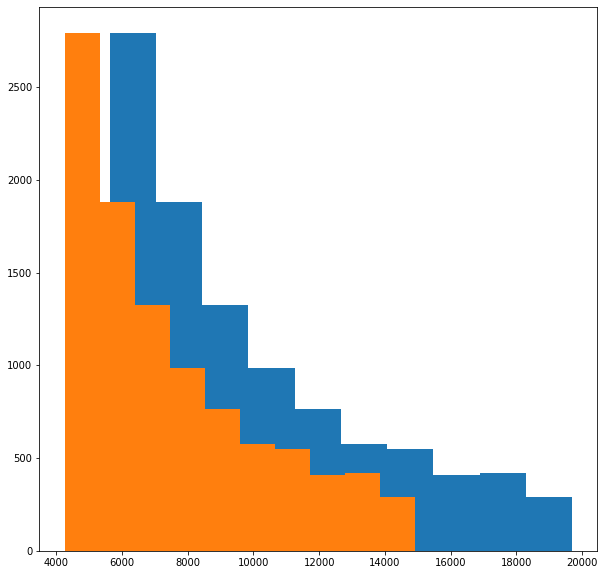

In [13]:
N = 100
net = op.network.Cubic(shape=[N, N, 1], spacing=2.5e-5)
geom = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)
water = op.phases.Water(network=net)
air = op.phases.Air(network=net)
air['pore.contact_angle'] = 105
phys_w = op.physics.Standard(network=net, phase=water, geometry=geom)
phys_w.add_model(propname='pore.entry_pressure',
                 model=op.models.physics.capillary_pressure.washburn,
                 diameter='pore.diameter')
phys_a = op.physics.Standard(network=net, phase=air, geometry=geom)
phys_a.add_model(propname='pore.entry_pressure',
                 model=op.models.physics.capillary_pressure.washburn,
                 diameter='pore.diameter')
phys_w['throat.entry_pressure'] = 0.0
phys_a['throat.entry_pressure'] = 0.0
fig, ax = plt.subplots(figsize=[10, 10])
ax.hist(phys_w['pore.entry_pressure'])
ax.hist(phys_a['pore.entry_pressure'])
plt.show()

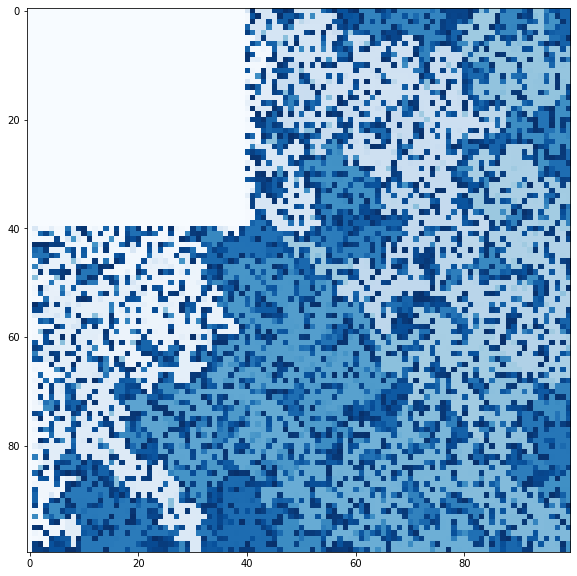

In [25]:
residual = np.zeros([N, N], dtype='bool')
residual[:40, :40] = True
alg1 = run_mp(phase=water, plot=True, residual=residual.flatten())

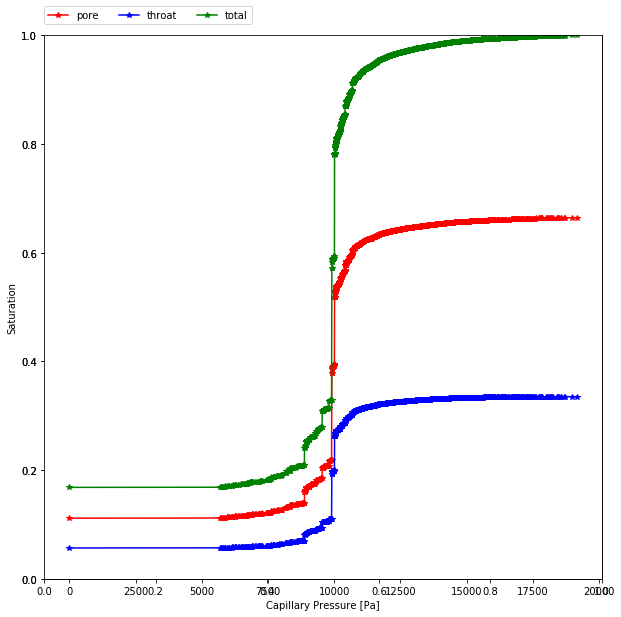

In [24]:
fig, ax = plt.subplots(figsize=[10, 10])
fig = alg1.plot_intrusion_curve(fig)
plt.show()

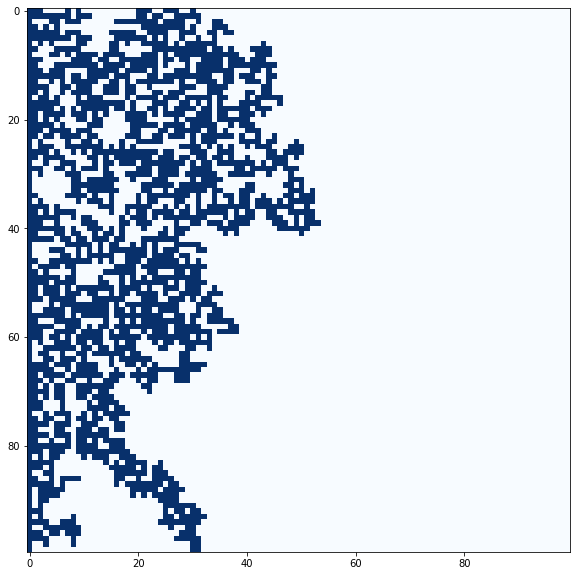

In [15]:
inj = mp(network=net)
inj.setup(phase=water)
inj.set_inlets(pores=net.pores('left'))
#inj.set_residual(pores=phase['pore.occupancy'])
inj.run(max_pressure=10000)
inj.set_outlets(net.pores(['back', 'front', 'right']))
#inj.apply_trapping()
inv_points = np.arange(0, 100, 1)
# returns data as well as plotting
alg_data = inj.get_intrusion_data(inv_points=inv_points)
fig, ax = plt.subplots(figsize=[10, 10])
L = np.sqrt(net.Np).astype(int)
mask = inj['pore.invasion_sequence'] > -1
ax.imshow(mask.reshape([L, L]),
           cmap=plt.get_cmap('Blues'))
plt.show()

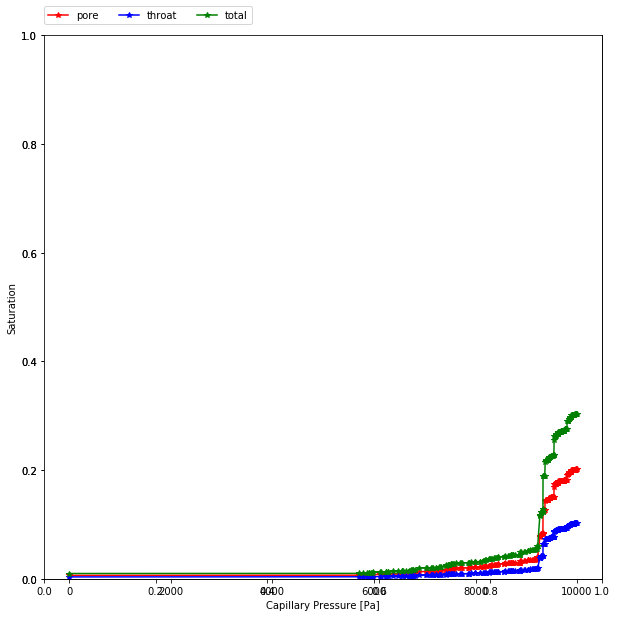

In [16]:
fig, ax = plt.subplots(figsize=[10, 10])
fig = inj.plot_intrusion_curve(fig)
plt.show()

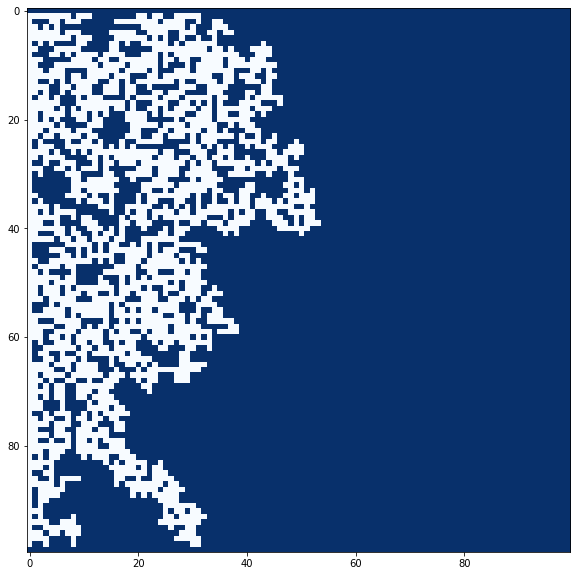

In [17]:
air['pore.occupancy'] = inj['pore.invasion_sequence'] == -1
withdrawal = mp(network=net)
withdrawal.setup(phase=air)
withdrawal.set_inlets(pores=net.pores(['back', 'front', 'right']))
withdrawal.set_residual(pores=air['pore.occupancy'])
withdrawal.run()
withdrawal.set_outlets(net.pores(['right']))
#inj.apply_trapping()
inv_points = np.arange(0, 100, 1)
# returns data as well as plotting
alg_data = withdrawal.get_intrusion_data(inv_points=inv_points)
fig, ax = plt.subplots(figsize=[10, 10])
L = np.sqrt(net.Np).astype(int)
mask = withdrawal['pore.invasion_sequence'] == 0
ax.imshow(mask.reshape([L, L]),
           cmap=plt.get_cmap('Blues'))